In [1]:
import os
import ast
import torch
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

from PIL import Image
from timm.models import create_model
from torchvision import transforms, datasets
from torch.utils.data import Dataset, DataLoader

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

e:\anaconda\envs\breast-cancer\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.2492, 0.2492, 0.2492], std=[0.1920, 0.1920, 0.1920]) # normalize with pretrain dataset (ssl)
])

val_dataset = datasets.ImageFolder(root=r"F:/code/CNUH_data/val", transform=val_transform)
val_loader = DataLoader(val_dataset, batch_size=int(1.0), num_workers=8, drop_last=False)

In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

model = create_model(
    "deit_base_patch16_224",
    pretrained=False,
    num_classes=2,
    drop_rate=0.1,
    drop_path_rate=0.2,
    drop_block_rate=None,
    img_size=224
)
model = model.to(device)

checkpoint_path = r"F:/code/ssl_mammo_599_base/best_acc_checkpoint.pth"
checkpoint = torch.load(checkpoint_path, map_location=device)

model.load_state_dict(checkpoint['model'])
model.eval()

def enable_dropout(m):
    if isinstance(m, torch.nn.Dropout):
        m.train()

def enable_droppath(m):
    if m.__class__.__name__ == "DropPath":
        m.train()

model.apply(enable_dropout)
model.apply(enable_droppath)

VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (patch_drop): Identity()
  (norm_pre): Identity()
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=768, out_features=2304, bias=True)
        (q_norm): Identity()
        (k_norm): Identity()
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): Identity()
      (drop_path1): Identity()
      (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dropout(p=0.0, inplace=False)
        (norm): Identity(

In [4]:
class InferenceDataset(Dataset):
    def __init__(self, csv_file, transform=None):
        self.data = pd.read_csv(csv_file)
        self.transform=transform

        self.label_map = {"grade 3": 0, "grade 4": 1}

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]

        patient_id = row["patient_id"]
        laterality = row["laterality"]
        grade = row["grade"]
        image_paths = ast.literal_eval(row["files"])

        patch_dict = {}
        for img_path in image_paths:
            filename = os.path.basename(img_path)
            patch_num = int(filename.split("_patch_")[1].split(".")[0])

            if patch_num not in patch_dict:
                patch_dict[patch_num] = []
            patch_dict[patch_num].append(img_path)

        grouped_images = []
        for patch_num in sorted(patch_dict.keys()):
            images = []
            for img_path in sorted(patch_dict[patch_num]):
                image = Image.open(img_path).convert('RGB')

                if self.transform:
                    image = self.transform(image)

                images.append(image)

            grouped_images.append(torch.stack(images))

        grouped_images = torch.stack(grouped_images)

        label = self.label_map[grade]

        return grouped_images, label

In [5]:
csv_file = "F:/code/CNUH_data/test_inference.csv"

test_dataset = InferenceDataset(csv_file, transform=val_transform)
test_loader = DataLoader(test_dataset, batch_size=1, num_workers=0)

final_outputs = []
true_labels = []
all_probs = []
excel_results = []

mc_runs = 100
sample_idx = 0

for i, (images, targets) in enumerate(test_loader):
    # images.shape = [batch_size, num_patches, num_views, C, H, W]
    batch_size, num_patches, num_views, C, H, W = images.shape

    for b_idx in range(batch_size):
        patch_probs_list = []
        for p_idx in range(num_patches):
            view_probs = []
            mean_prob_list = []
            for v_id in range(num_views):
                img_tensor = images[b_idx, p_idx, v_id].unsqueeze(0).to(device)
                with torch.no_grad(), torch.cuda.amp.autocast():
                    prob_list = []
                    for _ in range(mc_runs):
                        logits = model(img_tensor)
                        prob = torch.softmax(logits, dim=1)[:, 1].item()
                        prob_list.append(prob)

                mean_prob = np.mean(prob_list)
                mean_prob_list.append(mean_prob)
            
            average_prob = np.mean(mean_prob_list)
            patch_probs_list.append(average_prob)
        
        final_prob = max(patch_probs_list)

        final_pred = 1 if final_prob >= 0.5 else 0
        true_label = targets[b_idx].item()

        sample_dict = {"sample": sample_idx}
        sample_dict["final probability"] = final_prob
        sample_dict["final prediction"] = final_pred
        sample_dict["true label"] = true_label
        sample_dict["confidence"] = final_prob if final_prob >= 0.5 else 1 - final_prob

        excel_results.append(sample_dict)
        sample_idx += 1

    df = pd.DataFrame(excel_results)
    excel_file_path = r'F:/code/calibration_test/mc-dropout_results-uncalib.xlsx'
    df.to_excel(excel_file_path, index=False)

In [6]:
def calculate_calibration_metrics(file_path):
    df = pd.read_excel(file_path)
    
    # compute ECE
    bin_edges = [0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
    ece = 0.0
    accuracies = []
    case_ratio = []
    confidence = []

    for i in range(len(bin_edges) - 1):
        lower = bin_edges[i]
        upper = bin_edges[i+1]
        
        filtered_df = df[(df['confidence'] >= lower) & (df['confidence'] < upper)]
        
        if len(filtered_df) == 0:
            acc = 0.0
            conf = 0.0
            ratio = 0.0
        else:
            acc = float((filtered_df['true label'] == filtered_df['final prediction']).mean())
            conf = float(filtered_df['confidence'].mean())
            ratio = len(filtered_df) / len(df)
        
        accuracies.append(acc)
        confidence.append(conf)
        case_ratio.append(ratio)

    for i in range(len(bin_edges) - 1):
        ece += abs(accuracies[i] - confidence[i]) * case_ratio[i]

    # compute MCE
    bin_errors = [abs(acc - conf) for acc, conf in zip(accuracies, confidence)]
    mce = max(bin_errors)

    # compute Brier Score
    y_true = (df['true label'] == df['final prediction']).astype(int)
    y_prob = df['confidence']
    brier_score = np.mean((y_prob - y_true) ** 2)

    return {
        'ECE': ece,
        'MCE': mce,
        'Brier Score': brier_score,
        'Bin Accuracies': accuracies,
        'Bin Confidences': confidence,
        'Bin Ratios': case_ratio
    }

file_path = r'F:/code/calibration_test/mc-dropout_results-uncalib.xlsx'
metrics = calculate_calibration_metrics(file_path)

for key, value in metrics.items():
    print(f"{key}: {value}")

ECE: 0.1552203450162175
MCE: 0.19116787991353446
Brier Score: 0.1492698903977368
Bin Accuracies: [0.6428571428571429, 0.8, 0.9387755102040817, 1.0, 0.0]
Bin Confidences: [0.5496401663896228, 0.6513479277610779, 0.7476076302905472, 0.8100616727769374, 0.0]
Bin Ratios: [0.2641509433962264, 0.2358490566037736, 0.46226415094339623, 0.03773584905660377, 0.0]


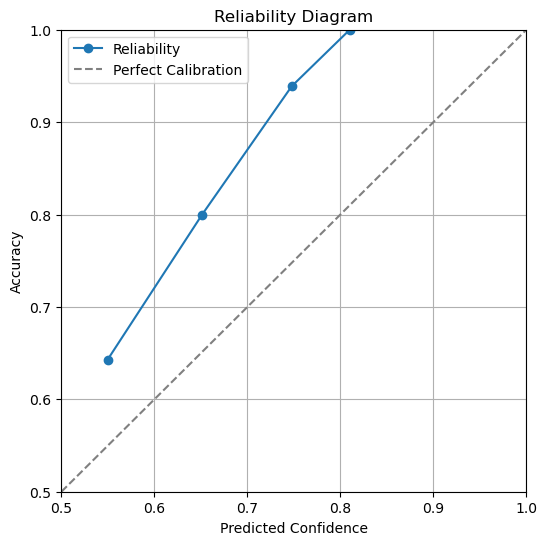

Bin information (excluding empty bins):
Bin 0: range=[0.5, 0.6), count=28, avg_conf=0.550, avg_acc=0.643
Bin 1: range=[0.6, 0.7), count=25, avg_conf=0.651, avg_acc=0.800
Bin 2: range=[0.7, 0.8), count=49, avg_conf=0.748, avg_acc=0.939
Bin 3: range=[0.8, 0.9), count=4, avg_conf=0.810, avg_acc=1.000


In [7]:
file_path = r'F:/code/calibration_test/mc-dropout_results-uncalib.xlsx'
df = pd.read_excel(file_path)

pred_probs = df['confidence']
true_labels = df['true label']

bin_edges = [0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

accuracies = []
avg_confidences = []
case_ratio = []

for i in range(len(bin_edges) - 1):
    lower = bin_edges[i]
    upper = bin_edges[i+1]
    
    filtered_df = df[(df['confidence'] >= lower) & (df['confidence'] < upper)]
    
    if len(filtered_df) == 0:
        acc = None
        conf = None
        ratio = 0.0
    else:
        acc = float((filtered_df['true label'] == filtered_df['final prediction']).mean())
        conf = float(filtered_df['confidence'].mean())
        ratio = len(filtered_df) / len(df)
    
    accuracies.append(acc)
    avg_confidences.append(conf)
    case_ratio.append(ratio)

plt.figure(figsize=(6, 6))

valid_indices = [i for i in range(len(bin_edges) - 1) if accuracies[i] is not None]

x_vals = [avg_confidences[i] for i in valid_indices]
y_vals = [accuracies[i]       for i in valid_indices]

plt.plot(x_vals, y_vals, marker='o', linestyle='-', label='Reliability')

plt.plot([0.5, 1.0], [0.5, 1.0], linestyle='--', color='gray', label='Perfect Calibration')

plt.xlabel('Predicted Confidence')
plt.ylabel('Accuracy')
plt.title('Reliability Diagram')
plt.xlim([0.5, 1.0])
plt.ylim([0.5, 1.0])
plt.legend()
plt.grid(True)
plt.show()

print("Bin information (excluding empty bins):")
for i in valid_indices:
    print(f"Bin {i}: range=[{bin_edges[i]}, {bin_edges[i+1]}), "
          f"count={case_ratio[i]*len(df):.0f}, "
          f"avg_conf={avg_confidences[i]:.3f}, "
          f"avg_acc={accuracies[i]:.3f}")

In [8]:
optimal_T = 0.626 # Optimal temperature scaling factor

csv_file = "F:/code/CNUH_data/test_inference.csv"

test_dataset = InferenceDataset(csv_file, transform=val_transform)
test_loader = DataLoader(test_dataset, batch_size=1, num_workers=0)

final_outputs = []
true_labels = []
all_probs = []
excel_results = []

mc_runs = 100
sample_idx = 0

for i, (images, targets) in enumerate(test_loader):
    # images.shape = [batch_size, num_patches, num_views, C, H, W]
    batch_size, num_patches, num_views, C, H, W = images.shape

    for b_idx in range(batch_size):
        patch_probs_list = []
        for p_idx in range(num_patches):
            view_probs = []
            mean_prob_list = []
            for v_id in range(num_views):
                img_tensor = images[b_idx, p_idx, v_id].unsqueeze(0).to(device)
                with torch.no_grad(), torch.cuda.amp.autocast():
                    prob_list = []
                    for _ in range(mc_runs):
                        logits = model(img_tensor)
                        # Apply temperature scaling
                        calibrated_logits = logits / optimal_T
                        prob = torch.softmax(calibrated_logits, dim=1)[:, 1].item()
                        prob_list.append(prob)
                
                mean_prob = np.mean(prob_list)
                mean_prob_list.append(mean_prob)
            
            average_prob = np.mean(mean_prob_list)
            patch_probs_list.append(average_prob)
        
        final_prob = max(patch_probs_list)

        final_pred = 1 if final_prob >= 0.5 else 0
        true_label = targets[b_idx].item()

        sample_dict = {"sample": sample_idx}
        sample_dict["final probability"] = final_prob
        sample_dict["final prediction"] = final_pred
        sample_dict["true label"] = true_label
        sample_dict["confidence"] = final_prob if final_prob >= 0.5 else 1 - final_prob

        excel_results.append(sample_dict)
        sample_idx += 1

    df = pd.DataFrame(excel_results)
    excel_file_path = r'F:/code/calibration_test/mc-dropout_results-calib.xlsx'
    df.to_excel(excel_file_path, index=False)

In [9]:
def calculate_calibration_metrics(file_path):
    df = pd.read_excel(file_path)
    
    # compute ECE
    bin_edges = [0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
    ece = 0.0
    accuracies = []
    case_ratio = []
    confidence = []

    for i in range(len(bin_edges) - 1):
        lower = bin_edges[i]
        upper = bin_edges[i+1]
        
        filtered_df = df[(df['confidence'] >= lower) & (df['confidence'] < upper)]
        
        if len(filtered_df) == 0:
            acc = 0.0
            conf = 0.0
            ratio = 0.0
        else:
            acc = float((filtered_df['true label'] == filtered_df['final prediction']).mean())
            conf = float(filtered_df['confidence'].mean())
            ratio = len(filtered_df) / len(df)
        
        accuracies.append(acc)
        confidence.append(conf)
        case_ratio.append(ratio)

    for i in range(len(bin_edges) - 1):
        ece += abs(accuracies[i] - confidence[i]) * case_ratio[i]

    # compute MCE
    bin_errors = [abs(acc - conf) for acc, conf in zip(accuracies, confidence)]
    mce = max(bin_errors)

    # compute Brier Score
    y_true = (df['true label'] == df['final prediction']).astype(int)
    y_prob = df['confidence']
    brier_score = np.mean((y_prob - y_true) ** 2)

    return {
        'ECE': ece,
        'MCE': mce,
        'Brier Score': brier_score,
        'Bin Accuracies': accuracies,
        'Bin Confidences': confidence,
        'Bin Ratios': case_ratio
    }

file_path = r'F:/code/calibration_test/mc-dropout_results-calib.xlsx'
metrics = calculate_calibration_metrics(file_path)

for key, value in metrics.items():
    print(f"{key}: {value}")

ECE: 0.08302604434519716
MCE: 0.12038596676333857
Brier Score: 0.13041964307369877
Bin Accuracies: [0.5789473684210527, 0.7647058823529411, 0.8421052631578947, 0.9361702127659575, 1.0]
Bin Confidences: [0.5544835966217674, 0.6443199155896026, 0.7500747000680942, 0.8472141567807885, 0.9100319321453572]
Bin Ratios: [0.1792452830188679, 0.16037735849056603, 0.1792452830188679, 0.44339622641509435, 0.03773584905660377]


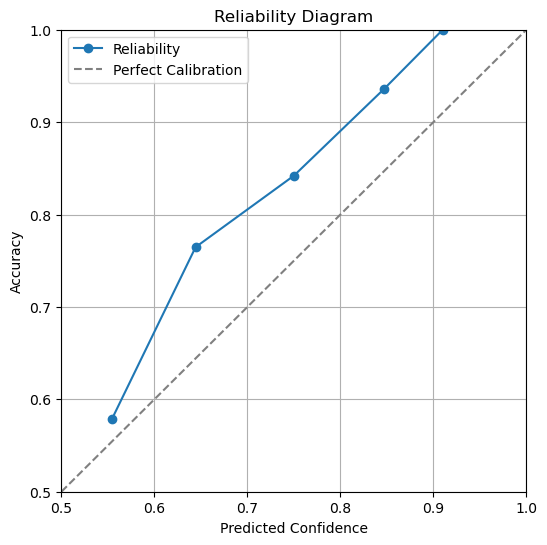

Bin information (excluding empty bins):
Bin 0: range=[0.5, 0.6), count=19, avg_conf=0.554, avg_acc=0.579
Bin 1: range=[0.6, 0.7), count=17, avg_conf=0.644, avg_acc=0.765
Bin 2: range=[0.7, 0.8), count=19, avg_conf=0.750, avg_acc=0.842
Bin 3: range=[0.8, 0.9), count=47, avg_conf=0.847, avg_acc=0.936
Bin 4: range=[0.9, 1.0), count=4, avg_conf=0.910, avg_acc=1.000


In [10]:
file_path = r'F:/code/calibration_test/mc-dropout_results-calib.xlsx'
df = pd.read_excel(file_path)

pred_probs = df['confidence']
true_labels = df['true label']

bin_edges = [0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

accuracies = []
avg_confidences = []
case_ratio = []

for i in range(len(bin_edges) - 1):
    lower = bin_edges[i]
    upper = bin_edges[i+1]
    
    filtered_df = df[(df['confidence'] >= lower) & (df['confidence'] < upper)]
    
    if len(filtered_df) == 0:
        acc = None
        conf = None
        ratio = 0.0
    else:
        acc = float((filtered_df['true label'] == filtered_df['final prediction']).mean())
        conf = float(filtered_df['confidence'].mean())
        ratio = len(filtered_df) / len(df)
    
    accuracies.append(acc)
    avg_confidences.append(conf)
    case_ratio.append(ratio)

plt.figure(figsize=(6, 6))

valid_indices = [i for i in range(len(bin_edges) - 1) if accuracies[i] is not None]

x_vals = [avg_confidences[i] for i in valid_indices]
y_vals = [accuracies[i]       for i in valid_indices]

plt.plot(x_vals, y_vals, marker='o', linestyle='-', label='Reliability')

plt.plot([0.5, 1.0], [0.5, 1.0], linestyle='--', color='gray', label='Perfect Calibration')

plt.xlabel('Predicted Confidence')
plt.ylabel('Accuracy')
plt.title('Reliability Diagram')
plt.xlim([0.5, 1.0])
plt.ylim([0.5, 1.0])
plt.legend()
plt.grid(True)
plt.show()

print("Bin information (excluding empty bins):")
for i in valid_indices:
    print(f"Bin {i}: range=[{bin_edges[i]}, {bin_edges[i+1]}), "
          f"count={case_ratio[i]*len(df):.0f}, "
          f"avg_conf={avg_confidences[i]:.3f}, "
          f"avg_acc={accuracies[i]:.3f}")

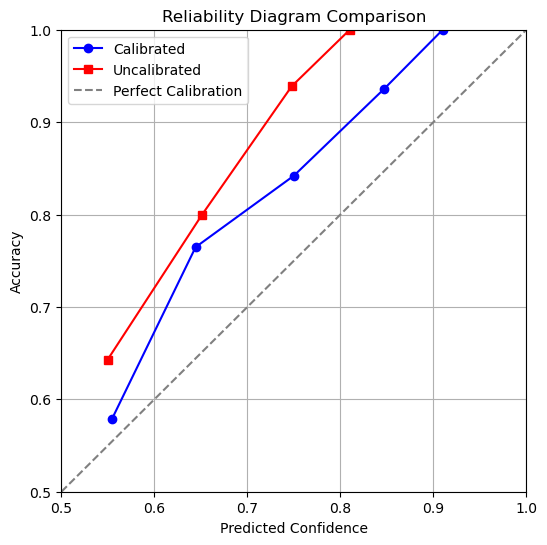

=== Calibrated Results ===
Bin 0: range=[0.5, 0.6), count=19, avg_conf=0.554, avg_acc=0.579
Bin 1: range=[0.6, 0.7), count=17, avg_conf=0.644, avg_acc=0.765
Bin 2: range=[0.7, 0.8), count=19, avg_conf=0.750, avg_acc=0.842
Bin 3: range=[0.8, 0.9), count=47, avg_conf=0.847, avg_acc=0.936
Bin 4: range=[0.9, 1.0), count=4, avg_conf=0.910, avg_acc=1.000

=== Uncalibrated Results ===
Bin 0: range=[0.5, 0.6), count=28, avg_conf=0.550, avg_acc=0.643
Bin 1: range=[0.6, 0.7), count=25, avg_conf=0.651, avg_acc=0.800
Bin 2: range=[0.7, 0.8), count=49, avg_conf=0.748, avg_acc=0.939
Bin 3: range=[0.8, 0.9), count=4, avg_conf=0.810, avg_acc=1.000


In [11]:
file_calib = r'F:/code/calibration_test/mc-dropout_results-calib.xlsx'
file_uncalib = r'F:/code/calibration_test/mc-dropout_results-uncalib.xlsx'

df_calib = pd.read_excel(file_calib)
df_uncalib = pd.read_excel(file_uncalib)

bin_edges = [0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

def compute_bin_info(df, bin_edges):
    accuracies = []
    avg_confidences = []
    case_ratio = []
    
    for i in range(len(bin_edges) - 1):
        lower = bin_edges[i]
        upper = bin_edges[i+1]
        
        filtered_df = df[(df['confidence'] >= lower) & (df['confidence'] < upper)]
        
        if len(filtered_df) == 0:
            acc = None
            conf = None
            ratio = 0.0
        else:
            acc = float((filtered_df['true label'] == filtered_df['final prediction']).mean())
            conf = float(filtered_df['confidence'].mean())
            ratio = len(filtered_df) / len(df)
        
        accuracies.append(acc)
        avg_confidences.append(conf)
        case_ratio.append(ratio)
    
    valid_indices = [i for i in range(len(bin_edges) - 1) if accuracies[i] is not None]
    x_vals = [avg_confidences[i] for i in valid_indices]
    y_vals = [accuracies[i] for i in valid_indices]
    
    return valid_indices, x_vals, y_vals, case_ratio, avg_confidences, accuracies

(valid_idx_calib, x_vals_calib, y_vals_calib, case_ratio_calib, avg_confidences_calib, accuracies_calib) = compute_bin_info(df_calib, bin_edges)
(valid_idx_uncalib, x_vals_uncalib, y_vals_uncalib, case_ratio_uncalib, avg_confidences_uncalib, accuracies_uncalib) = compute_bin_info(df_uncalib, bin_edges)

plt.figure(figsize=(6, 6))

# draw calibrated results
plt.plot(x_vals_calib, y_vals_calib, marker='o', linestyle='-', color='blue', label='Calibrated')
# draw uncalibrated results
plt.plot(x_vals_uncalib, y_vals_uncalib, marker='s', linestyle='-', color='red', label='Uncalibrated')
# draw perfect calibration line
plt.plot([0.5, 1.0], [0.5, 1.0], linestyle='--', color='gray', label='Perfect Calibration')

plt.xlabel('Predicted Confidence')
plt.ylabel('Accuracy')
plt.title('Reliability Diagram Comparison')
plt.xlim([0.5, 1.0])
plt.ylim([0.5, 1.0])
plt.legend()
plt.grid(True)
plt.show()

print("=== Calibrated Results ===")
for i in valid_idx_calib:
    count = case_ratio_calib[i]*len(df_calib)
    print(f"Bin {i}: range=[{bin_edges[i]}, {bin_edges[i+1]}), count={count:.0f}, avg_conf={avg_confidences_calib[i]:.3f}, avg_acc={accuracies_calib[i]:.3f}")

print("\n=== Uncalibrated Results ===")
for i in valid_idx_uncalib:
    count = case_ratio_uncalib[i]*len(df_uncalib)
    print(f"Bin {i}: range=[{bin_edges[i]}, {bin_edges[i+1]}), count={count:.0f}, avg_conf={avg_confidences_uncalib[i]:.3f}, avg_acc={accuracies_uncalib[i]:.3f}")